In [101]:
# import library
import warnings
import numpy as np
from scipy import linalg
from sklearn.datasets import fetch_olivetti_faces
import sys
import matplotlib.pyplot as plt

In [60]:
# import the data
data = fetch_olivetti_faces()
face_images = data.data
print(face_images.shape)

(400, 4096)


In [74]:
# Activation Functions
def _logcosh(x, fun_args=None):
    alpha = 1.0  # comment it out?
    x *= alpha
    gx = np.tanh(x, x)  # apply the tanh inplace
    g_x = np.empty(x.shape[0])
    # XXX compute in chunks to avoid extra allocation
    for i, gx_i in enumerate(gx):  # please don't vectorize.
        g_x[i] = (alpha * (1 - gx_i ** 2)).mean()
    return gx, g_x
def _exp(x, fun_args):
    exp = np.exp(-(x ** 2) / 2)
    gx = x * exp
    g_x = (1 - x ** 2) * exp
    return gx, g_x.mean(axis=-1)
def _cube(x, fun_args):
    return x ** 3, (3 * x ** 2).mean(axis=-1)

In [127]:
# Fast ICA
def _sym_decorrelation(W):
    """ Symmetric decorrelation
    i.e. W <- (W * W.T) ^{-1/2} * W
    """
    s, u = linalg.eigh(np.dot(W, W.T))
    return np.dot(np.dot(u * (1. / np.sqrt(s)), u.T), W)

def _ica_par(X, tol, g, fun_args, max_iter, w_init):
    W = _sym_decorrelation(w_init)
    del w_init
    p_ = float(X.shape[1])
    for ii in range(max_iter):
        gwtx, g_wtx = g(np.dot(W, X), fun_args)
        W1 = _sym_decorrelation(np.dot(gwtx, X.T) / p_ - g_wtx[:, np.newaxis] * W)
        del gwtx, g_wtx
        # builtin max, abs are faster than numpy counter parts.
        lim = max(abs(abs(np.diag(np.dot(W1, W.T))) - 1))
        W = W1
        if lim < tol:
            break
    else:
        warnings.warn('FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.')
    return W, ii + 1

def fastica(X, n_components=None, algorithm="parallel", whiten=True,
            fun="logcosh", fun_args=None, max_iter=200, tol=1e-04, w_init=None,
            random_state=None, return_X_mean=False, compute_sources=True,):

    if fun == 'logcosh':
        g = _logcosh
    elif fun == 'exp':
        g = _exp
    elif fun == 'cube':
        g = _cube

    n, p = X.shape
    if not whiten and n_components is not None:
        n_components = None
        warnings.warn('Ignoring n_components with whiten=False.')

    if whiten:
        # Centering the columns (ie the variables)
        X_mean = X.mean(axis=-1)
        X -= X_mean[:, np.newaxis]

        # Whitening and preprocessing by PCA
        u, d, _ = linalg.svd(X, full_matrices=False)

        del _
        K = (u / d).T[:n_components]  # see (6.33) p.140
        del u, d
        X1 = np.dot(K, X)

        # see (13.6) p.267 Here X1 is white and data in X has been projected onto a subspace by PCA
        X1 = X1 * np.sqrt(p)
        w_init =  np.random.normal(size=(n_components,n_components))

    else:
        # X must be casted to floats to avoid typing issues with numpy
        # 2.0 and the line below
        X1 = X.astype(np.float64).copy()
#         w_init =  np.random.normal(size=(n_components,X.shape[0]))
        w_init =  np.random.normal(size=(100,400))


    kwargs = {'tol': tol,'g': g,'fun_args': fun_args,'max_iter': max_iter,'w_init': w_init}
    
    W, n_iter = _ica_par(X1, **kwargs)

    if whiten:
        if compute_sources:
            S = np.dot(np.dot(W, K), X).T
        else:
            S = None
        if return_X_mean:
            return K, W, S, X_mean
        else:
            return K, W, S
    else:
        if compute_sources:
            S = np.dot(W, X).T
        else:
            S = None
        if return_X_mean:
            return None, W, S, None
        else:
            return None, W, S

In [128]:
algo = fastica(face_images,n_components=100,max_iter=1000,tol=1e-10,whiten=False,compute_sources=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: Ignoring n_components with whiten=False.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.


In [130]:
print(len(algo))
try:
    print(algo[0].shape)
    print(algo[1].shape)
    print(algo[2].shape)
except:
    pass

3


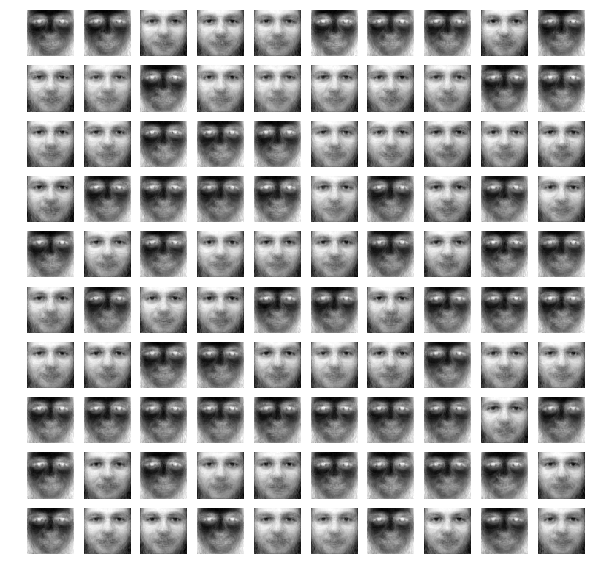

In [131]:
algo_show = algo[2].reshape(64,64,100)
w=10
h=10
fig=plt.figure(figsize=(10, 10))
columns = 10
rows = 10
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(algo_show[:,:,i-1],cmap='gray')
plt.show()

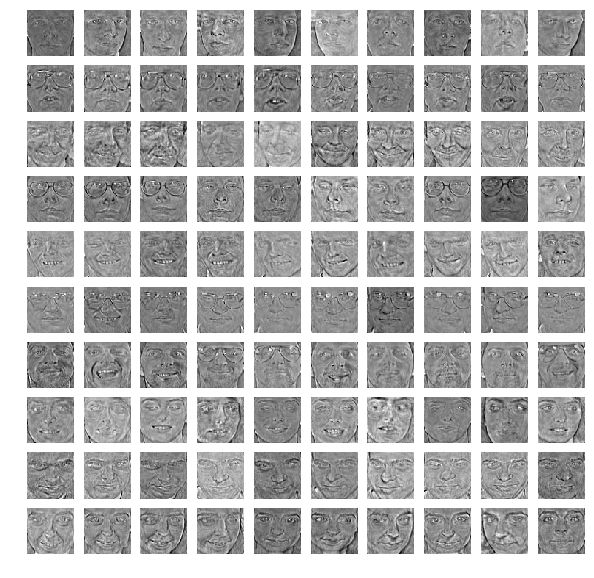

In [135]:
# zca whiten
def zca_whiten(X):
    """
    Applies ZCA whitening to the data (X)
    http://xcorr.net/2011/05/27/whiten-a-matrix-matlab-code/

    X: numpy 2d array
        input data, rows are data points, columns are features

    Returns: ZCA whitened 2d array
    """
    assert(X.ndim == 2)
    EPS = 10e-5

    #   covariance matrix
    cov = np.dot(X.T, X)
    #   d = (lambda1, lambda2, ..., lambdaN)
    d, E = np.linalg.eigh(cov)
    #   D = diag(d) ^ (-1/2)
    D = np.diag(1. / np.sqrt(d + EPS))
    #   W_zca = E * D * E.T
    W = np.dot(np.dot(E, D), E.T)

    X_white = np.dot(X, W)

    return X_white
zca_white = zca_whiten(face_images.T).T
zca_white_reshape = zca_white.reshape(400,64,64)
w=10
h=10
fig=plt.figure(figsize=(10, 10))
columns = 10
rows = 10
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(zca_white_reshape[i-1],cmap='gray')
plt.show()

In [136]:
algo_zca = fastica(zca_white,n_components=100,max_iter=1000,tol=1e-10,whiten=False,compute_sources=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: Ignoring n_components with whiten=False.


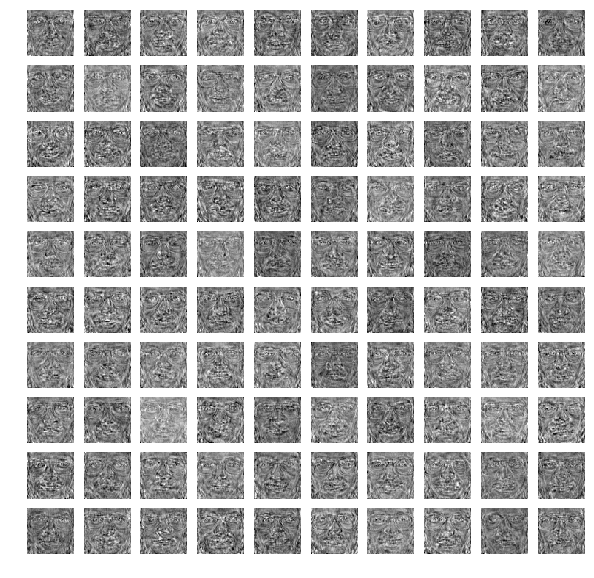

In [137]:
algo_zca_zca = algo_zca[2].reshape(64,64,100)
w=10
h=10
fig=plt.figure(figsize=(10, 10))
columns = 10
rows = 10
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(algo_zca_zca[:,:,i-1],cmap='gray')
plt.show()

In [138]:
! git add .
! git commit -m "from mac"
! git push

[master 3ce23445] from mac
 2 files changed, 275 insertions(+), 52 deletions(-)
Counting objects: 8, done.
Delta compression using up to 4 threads.
Compressing objects: 100% (8/8), done.
Writing objects: 100% (8/8), 1.71 MiB | 939.00 KiB/s, done.
Total 8 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/JaeDukSeo/Daily-Neural-Network-Practice-2
   03e5d910..3ce23445  master -> master


/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


(100, 64, 64)


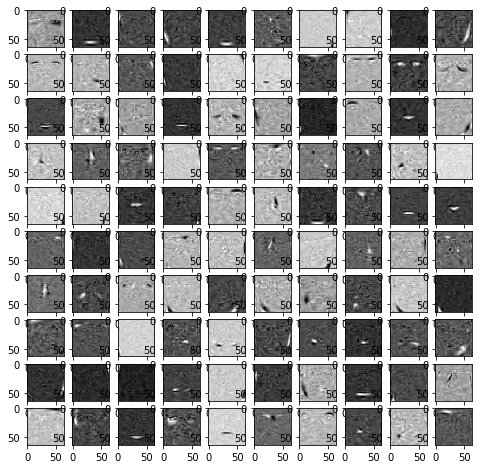

In [92]:
from sklearn.decomposition import FastICA
ee = FastICA(n_components=100,max_iter=1000,tol=1e-10)
ddddd = ee.fit_transform(face_images.T).T.reshape(100,64,64)
print(ddddd.shape)
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 10
rows = 10
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    try:
        plt.imshow(ddddd[i-1],cmap='gray')
    except:
        pass
plt.show()